In [2]:
from dotenv import load_dotenv
import pandas as pd
from tqdm.notebook import tqdm
import os

tqdm.pandas()

_ = load_dotenv()

GH_USER = os.environ["GH_USERNAME"]
GH_TOKEN = os.environ["GH_TOKEN"]

In [5]:
sampled_repo_graphics_df = pd.read_csv("sampled_repo_graphics_df.csv")
sampled_repo_graphics_df

,Project,Last_Activity,Contributors,Stargazers,Graphic_Files,Graphic_Files_Length
0,sprossiter/JSIT/,2024-08-26 23:12:56+00:00,1.0,2.0,['src/main/resources/docs/diagrams/alAddDepend...,6
1,baidu/broc/,2024-10-25 16:02:35+00:00,4.0,100.0,"['doc/dependent_relationship.jpg', 'doc/flowch...",3
2,telldus/telldus/,2024-09-09 12:44:16+00:00,10.0,64.0,['telldus-gui/3rdparty/qtsingleapplication/doc...,106
3,Splamy/TS3AudioBot/,2024-11-14 13:01:16+00:00,12.0,698.0,"['TS3AudioBot/Media/SleepingKitty.png', 'TS3Au...",5
4,benmfaul/XRTB/,2024-05-17 07:27:22+00:00,1.0,121.0,"['src/Test.uml', 'src/com/xrtb/bidder/Campaign...",54
...,...,...,...,...,...,...
211,Vdragon/NTOU_CPP_Lab_Opensource_Project/,2024-03-19 13:36:53+00:00,0.0,3.0,"['Lab_6_1/Class_diagram/Lab 6-1.uml', 'Lab_6_2...",2
212,tarbrain/TBStateMachine/,2024-02-13 10:47:56+00:00,1.0,49.0,['Documentation/test_setup.png'],1
213,apache/click/,2024-10-07 04:28:28+00:00,4.0,14.0,['documentation/docs/velocity/images/logo.gif'...,135
214,streambuf/recognition_numbers/,2024-04-16 11:26:55+00:00,1.0,12.0,"['screenshots/1.png', 'screenshots/2.png', 'sc...",4


In [6]:
sampled_repo_graphics_df['Graphic_Files_Length'].sum()

61065

## Check if graphics is UML class diagram

This is a combination of LLM and manual filtering

In [4]:
import torch 
torch.cuda.is_available()

True

In [5]:
from transformers import AutoModel, AutoTokenizer

filepath_model = "C:/Users/biadge/MiniCPM-o-2_6"  # path to the model
model = AutoModel.from_pretrained(filepath_model, 
                                  trust_remote_code=True, 
                                  use_safetensors=True,
                                  attn_implementation='sdpa', 
                                  torch_dtype=torch.bfloat16, 
                                  init_vision=True,
                                  init_audio=True,
                                  init_tts=True)

model = model.eval().cuda()

tokenizer = AutoTokenizer.from_pretrained(filepath_model, trust_remote_code=True)
model.init_tts()

c:\Users\biadge\uml_code_traceability\.venv\Lib\site-packages\transformers\models\auto\image_processing_auto.py:513: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
import requests
import os
from PIL import Image

def run_detect_uml(model, tokenizer, project, file):

    image_url = f"https://raw.githubusercontent.com/{project[:-1]}/master/{file}".format(project=project, file=file)

    # from the image url, download the image to a temporary file which will be deleted later

    os.makedirs(f'images/{project}', exist_ok=True)
    with open(f'images/{project}/{os.path.basename(file)}', 'wb') as f:
        f.write(requests.get(image_url).content)

    try:
        image = Image.open(f'images/{project}/{os.path.basename(file)}').convert('RGB')

        question = "Is this image a UML class diagram? Only answer 'True' if yes or 'False' if no."
        msgs=[{'role': 'user', 
           'content': [image,question]}]
        res = model.chat(
        msgs=msgs,
        tokenizer=tokenizer
    )
    except:
        return "Error"
    finally:
        os.remove(f'images/{project}/{os.path.basename(file)}')

    return res

In [7]:
# uncomment this to run LLM check images for UML class diagram

# from tqdm.notebook import tqdm
# import ast
# tqdm.pandas()

# range_df = range(22)

# for ctr in range_df:
#     print(f"Processing chunk {ctr}")

#     sampled_repo_graphics_df = pd.read_csv(f"sampled_repo_graphics_df_{ctr}.csv")

#     sampled_repo_graphics_df['Graphic_Files'] = sampled_repo_graphics_df['Graphic_Files'].apply(lambda x: ast.literal_eval(x))
#     sampled_repo_graphics_df = sampled_repo_graphics_df.explode('Graphic_Files')
#     sampled_repo_graphics_df = sampled_repo_graphics_df.drop(columns=['Graphic_Files_Length'])
#     sampled_repo_graphics_df = sampled_repo_graphics_df.reset_index(drop=True)

#     print(sampled_repo_graphics_df.shape)

#     sampled_repo_graphics_df['Is_UML'] = sampled_repo_graphics_df.progress_apply(lambda x: run_detect_uml(model, tokenizer, x['Project'], x['Graphic_Files']), axis=1)
#     sampled_repo_graphics_df.to_csv(f"sampled_repo_graphics_uml_df_{ctr}.csv", index=False) 


In [8]:
def run_detect_class_diagram(model, tokenizer, project, file):

    image_url = f"https://raw.githubusercontent.com/{project[:-1]}/master/{file}".format(project=project, file=file)

    # from the image url, download the image to a temporary file which will be deleted later

    os.makedirs(f'llm_check/{project}', exist_ok=True)
    with open(f'llm_check/{project}/{os.path.basename(file)}', 'wb') as f:
        f.write(requests.get(image_url).content)

    try:

        with open(f'llm_check/{project}/{os.path.basename(file)}', 'rb') as file:
            content = file.read()

        question = "Is this image a UML class diagram? Only answer 'True' if yes or 'False' if no."
        msgs=[{'role': 'user', 
           'content': [content,question]}]
        res = model.chat(
        msgs=msgs,
        tokenizer=tokenizer
    )
    except Exception as e:
        print(f"Error with {project} {file}")
        print(e)
        return "Error"

    return res

In [14]:
# get results of LLM and manual filtering

sampled_repo_graphics_uml_df = pd.read_csv("sampled_repo_graphics_uml_df.csv")
sampled_repo_graphics_uml_df = sampled_repo_graphics_uml_df[sampled_repo_graphics_uml_df['Is_UML']]
sampled_repo_graphics_uml_df['File_Type'] = sampled_repo_graphics_uml_df['Graphic_Files'].apply(lambda x: x.rsplit('.', 1)[-1]) 
sampled_repo_graphics_uml_df = sampled_repo_graphics_uml_df[sampled_repo_graphics_uml_df['File_Type'].apply(lambda x: x not in {'uml', 'xmi', 'plantuml', 'puml'})]
sampled_repo_graphics_uml_df = sampled_repo_graphics_uml_df.drop(columns=['Is_UML', 'File_Type']).reset_index(drop=True)
class_diagrams_df = sampled_repo_graphics_uml_df.rename(columns={'Graphic_Files': 'Class_Diagram_File'})
class_diagrams_df = class_diagrams_df.sort_values(by=['Project', 'Class_Diagram_File']).reset_index(drop=True)
class_diagrams_df

,Project,Last_Activity,Contributors,Stargazers,Class_Diagram_File
0,4dnucleome/cog-abm/,2024-08-09 17:24:23+00:00,3,6,AgentClassDiagram.png
1,4dnucleome/cog-abm/,2024-08-09 17:24:23+00:00,3,6,SimulationClassDiagram.png
2,4dnucleome/cog-abm/,2024-08-09 17:24:23+00:00,3,6,doc/AgentClassDiagram.png
3,4dnucleome/cog-abm/,2024-08-09 17:24:23+00:00,3,6,doc/SimulationClassDiagram.png
4,AOKP/frameworks_base_disabled/,2024-07-22 03:39:30+00:00,30,93,docs/html/images/animation/valueanimator.png
...,...,...,...,...,...
929,wyon/note/,2024-08-23 06:52:12+00:00,1,0,design_patterns/img/patterns_state.png
930,wyon/note/,2024-08-23 06:52:12+00:00,1,0,design_patterns/img/patterns_strategy.png
931,wyon/note/,2024-08-23 06:52:12+00:00,1,0,design_patterns/img/patterns_template_method.png
932,wyon/note/,2024-08-23 06:52:12+00:00,1,0,design_patterns/img/patterns_visitor.png


In [15]:
class_diagrams_df.to_csv("class_diagrams_df.csv", index=False)

In [19]:
from tqdm.notebook import tqdm
import requests
import os

tqdm.pandas()

dup_files = []
ori_files = []

def download_diagram(project, file):

    try:
        image_url = f"https://raw.githubusercontent.com/{project[:-1]}/master/{file}".format(project=project, file=file)

        os.makedirs(f'class_diagrams/{project}', exist_ok=True)

        file_path = f'class_diagrams/{project}/{os.path.basename(file)}'
        if os.path.exists(file_path):
            ori_files.append(file_path)
            file = file.replace('/', '-')
            file_path = f'class_diagrams/{project}/{file}'
            dup_files.append(file_path)
            
        with open(file_path, 'wb') as f:
            f.write(requests.get(image_url).content)

    except Exception as e:
        print(f"Error downloading {file} from {project}: {e}")

In [20]:
class_diagrams_df.progress_apply(lambda x: download_diagram(x['Project'], x['Class_Diagram_File']), axis=1)

  0%|          | 0/934 [00:00<?, ?it/s]

0      None
1      None
2      None
3      None
4      None
       ... 
929    None
930    None
931    None
932    None
933    None
Length: 934, dtype: object

In [21]:
# count number of files in 'class_diagrams' folder and subfolders
def count_files(path):
    count = 0
    for root, dirs, files in os.walk(path):
        count += len(files)
    return count

count_files('class_diagrams')

934

In [85]:
# count number of files in 'class_diagrams' folder and subfolders, AFTER DUPLICATES REMOVED
def count_files(path):
    count = 0
    for root, dirs, files in os.walk(path):
        count += len(files)
    return count

count_files('class_diagrams')

749

In [86]:
934 - 185 # to confirm that 185 duplicate files were removed

749

In [58]:
class_diagrams_df = pd.read_csv("class_diagrams_df.csv")
class_diagrams_df = class_diagrams_df[class_diagrams_df['Duplicate?'] == False].drop(columns=['Duplicate?']).reset_index(drop=True)
class_diagrams_df

,Project,Last_Activity,Contributors,Stargazers,Class_Diagram_File
0,4dnucleome/cog-abm/,2024-08-09 17:24:23+00:00,3,6,AgentClassDiagram.png
1,4dnucleome/cog-abm/,2024-08-09 17:24:23+00:00,3,6,SimulationClassDiagram.png
2,4dnucleome/cog-abm/,2024-08-09 17:24:23+00:00,3,6,doc/AgentClassDiagram.png
3,4dnucleome/cog-abm/,2024-08-09 17:24:23+00:00,3,6,doc/SimulationClassDiagram.png
4,abreitenfeld/QCrystalTile/,2024-03-19 11:37:18+00:00,5,1,doc/architecture/architecture.svg
...,...,...,...,...,...
744,wyon/note/,2024-08-23 06:52:12+00:00,1,0,design_patterns/img/patterns_state.png
745,wyon/note/,2024-08-23 06:52:12+00:00,1,0,design_patterns/img/patterns_strategy.png
746,wyon/note/,2024-08-23 06:52:12+00:00,1,0,design_patterns/img/patterns_template_method.png
747,wyon/note/,2024-08-23 06:52:12+00:00,1,0,design_patterns/img/patterns_visitor.png


In [59]:
print(f'No. of projects: {class_diagrams_df["Project"].nunique()}')
print(f'No. of class diagrams: {class_diagrams_df.shape[0]}')

No. of projects: 105
No. of class diagrams: 749


In [14]:
projects_df = pd.DataFrame(class_diagrams_df['Project'].unique())
projects_df.columns = ['Project']
projects_df

,Project
0,4dnucleome/cog-abm/
1,abreitenfeld/QCrystalTile/
2,abulka/pynsource/
3,ackepenek/HavayoluSirketSistemi/
4,adityaapte/CERR/
...,...
100,wolandscat/EOMF/
101,WouterJ/wouterj.github.com/
102,wro4j/wro4j-examples/
103,wyon/note/


In [15]:
def get_lines_of_code(repo_name):
    try:
        r = requests.get(f'https://api.github.com/repos/{repo_name}/languages', auth=(GH_USER, GH_TOKEN), timeout=60)
        r.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f'Error: {e}')
        return None

    languages = r.json()
    total_lines = sum(languages.values())
    return total_lines

def add_lines_of_code(df):
    tqdm.pandas()
    df['Lines_of_Code'] = df['Project'].progress_apply(lambda repo: get_lines_of_code(repo[:-1]))
    return df

In [26]:
projects_loc_df = add_lines_of_code(projects_df)
projects_loc_df = projects_loc_df[projects_loc_df['Lines_of_Code']>0]

  0%|          | 0/105 [00:00<?, ?it/s]

In [27]:
projects_loc_df.sort_values(by='Lines_of_Code', ascending=False)

,Project,Lines_of_Code
26,blackberry/BB10-WebWorks-Community-Samples/,91721751
86,UnboundID/ldapsdk/,88974637
87,Unidata/awips2/,79543836
10,AOKP/frameworks_base_disabled/,53066690
79,TimLethbridge/umple/,50060767
...,...,...
36,chuxi/chuxi.github.io/,25039
41,sbhatore/SSAD46/,17132
103,wyon/note/,11330
72,symfony/symfony1-docs/,5181


In [30]:
class_diagrams_grouped_df = class_diagrams_df.groupby('Project').size().reset_index(name='No_of_Class_Diagrams')
class_diagrams_grouped_df = class_diagrams_grouped_df.merge(projects_loc_df, on='Project', how='right')
class_diagrams_grouped_df['UML_LOC_ratio'] = class_diagrams_grouped_df['No_of_Class_Diagrams'] / class_diagrams_grouped_df['Lines_of_Code']
class_diagrams_grouped_df

,Project,No_of_Class_Diagrams,Lines_of_Code,UML_LOC_ratio
0,4dnucleome/cog-abm/,4,218076,1.834223e-05
1,abreitenfeld/QCrystalTile/,1,201201,4.970154e-06
2,abulka/pynsource/,15,7428438,2.019267e-06
3,adityaapte/CERR/,3,36085779,8.313524e-08
4,afarber/alexander-farber/,2,1057270,1.891664e-06
...,...,...,...,...
98,wolandscat/EOMF/,2,2938437,6.806340e-07
99,WouterJ/wouterj.github.com/,2,138126,1.447953e-05
100,wro4j/wro4j-examples/,1,11560695,8.649999e-08
101,wyon/note/,21,11330,1.853486e-03


In [35]:
# normalise the UML LOC ratio column
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

class_diagrams_grouped_df['UML_LOC_ratio_scaled'] = scaler.fit_transform(class_diagrams_grouped_df[['UML_LOC_ratio']])
class_diagrams_grouped_df.drop(columns=['UML_LOC_ratio'], inplace=True)
class_diagrams_grouped_df.sort_values(by='UML_LOC_ratio_scaled', ascending=False, inplace=True, ignore_index=True)
class_diagrams_grouped_df

,Project,No_of_Class_Diagrams,Lines_of_Code,UML_LOC_ratio_scaled
0,wyon/note/,21,11330,1.000000e+00
1,wangkuiwu/wangkuiwu.github.io/,44,34570,6.866932e-01
2,xenodium/xenodium.github.io/,1,1705,3.164322e-01
3,symfony/symfony1-docs/,3,5181,3.124012e-01
4,bootchk/pensool/,58,268079,1.167230e-01
...,...,...,...,...
98,Unidata/awips2/,2,79543836,7.683312e-06
99,wakaleo/game-of-life/,1,43114062,6.631730e-06
100,AOKP/frameworks_base_disabled/,1,53066690,4.284747e-06
101,UnboundID/ldapsdk/,1,88974637,1.816148e-07


In [63]:
sampled_class_diagrams_df = class_diagrams_df.merge(class_diagrams_grouped_df, on='Project').sort_values(by='UML_LOC_ratio_scaled', ascending=False).reset_index(drop=True)
sampled_class_diagrams_df.to_csv("sampled_class_diagrams_df.csv", index=False)
sampled_class_diagrams_df

,Project,Last_Activity,Contributors,Stargazers,Class_Diagram_File,No_of_Class_Diagrams,Lines_of_Code,UML_LOC_ratio_scaled
0,wyon/note/,2024-08-23 06:52:12+00:00,1,0,design_patterns/img/patterns_bridge.png,21,11330,1.000000e+00
1,wyon/note/,2024-08-23 06:52:12+00:00,1,0,design_patterns/img/patterns_mediator.png,21,11330,1.000000e+00
2,wyon/note/,2024-08-23 06:52:12+00:00,1,0,design_patterns/img/pattens_abstract_factory.png,21,11330,1.000000e+00
3,wyon/note/,2024-08-23 06:52:12+00:00,1,0,design_patterns/img/patterns_builder.png,21,11330,1.000000e+00
4,wyon/note/,2024-08-23 06:52:12+00:00,1,0,design_patterns/img/patterns_china_of_responsi...,21,11330,1.000000e+00
...,...,...,...,...,...,...,...,...
713,Unidata/awips2/,2024-11-14 08:16:50+00:00,2,177,cave/com.raytheon.viz.gfe/help/images/TF10.png,2,79543836,7.683312e-06
714,wakaleo/game-of-life/,2024-11-12 11:04:29+00:00,6,2037,gameoflife-web/tools/jmeter/docs/images/screen...,1,43114062,6.631730e-06
715,AOKP/frameworks_base_disabled/,2024-07-22 03:39:30+00:00,30,93,docs/html/images/animation/valueanimator.png,1,53066690,4.284747e-06
716,UnboundID/ldapsdk/,2024-11-13 22:03:09+00:00,1,338,ext/ant/manual/Tasks/image-classdiagram.gif,1,88974637,1.816148e-07


### Get old UML models

In [11]:
sampled_class_diagrams_df = pd.read_csv("sampled_class_diagrams_df.csv")
sampled_class_diagrams_grouped_df = sampled_class_diagrams_df.groupby('Project')['Class_Diagram_File'].apply(list).reset_index(name='Class_Diagram_Files')
sampled_class_diagrams_grouped_df['No_of_Class_Diagrams'] = sampled_class_diagrams_grouped_df['Class_Diagram_Files'].apply(len)
sampled_class_diagrams_grouped_df

,Project,Class_Diagram_Files,No_of_Class_Diagrams
0,4dnucleome/cog-abm/,"[doc/AgentClassDiagram.png, doc/SimulationClas...",4
1,AOKP/frameworks_base_disabled/,[docs/html/images/animation/valueanimator.png],1
2,AlessandroSanino1994/NerdOrDungeons/,[UML/UML.png],1
3,AnalogDevicesLyricLabs/dimple/,[modelers/matlab/lib/xunit_dist/matlab_xunit/a...,3
4,Andresteve07/FINAL_AyED/,[Informe/Imagenes/Diagrama_Clases_Final_AyED_v...,3
...,...,...,...
98,wimleers/sudoku/,"[doc/images/UML_4.png, doc/images/UML_3.png, d...",5
99,wolandscat/EOMF/,"[doc/uml/BMM_classes.png, doc/uml/P_BMM_classe...",2
100,wro4j/wro4j-examples/,[wro4j-demo/doc/WRO - ClassDiagram.jpg],1
101,wyon/note/,"[design_patterns/img/patterns_bridge.png, desi...",21


In [12]:
sampled_class_diagrams_grouped_df['No_of_Class_Diagrams'].sum()

721

In [5]:
full_repo_model_df = pd.read_csv('UMLFiles_List_V2.0.csv')

# clean the string in model link to just reflect file name similar to UML files in uml_loc_df, include the directory from root
full_repo_model_df['Model Link - Github'] = full_repo_model_df['Model Link - Github'].apply(lambda x: x.split('master/')[-1])

# groupby the Projects
grouped_models_df = full_repo_model_df.groupby('Project')['Model Link - Github'].apply(list).reset_index()

# # every element in the model link list to be encaved in ' ' since they are strings
# grouped_models_df['Model Link - Github'] = grouped_models_df['Model Link - Github'].apply(lambda x: [f"'{y}'" for y in x])

# rename the columns
grouped_models_df.rename(columns={'Model Link - Github': 'UML_Diagrams_previous'}, inplace=True)
grouped_models_df

,Project,UML_Diagrams_previous
0,0-complexity/ovcdoc_public/,[Sysadmin/AdminArchitecture.png]
1,0003088/libelektra-qt-gui-test/,[doc/images/overview_plugins.xmi]
2,00s/deadman/,[diagram/zombie-game Activity Diagram.png]
3,01db0y/ImageUploader/,[Content/img/Class Diagram1.png]
4,01db0y/ShareIt/,[FancyImageUploader/Content/img/Class Diagram1...
...,...,...
24725,zyq001/SDN-based-PubSub-System/,[wsn-sdn/logs/umltest.uml]
24726,zyxstar/md_note/,"[imgs/effective_uml_01.png, imgs/effective_uml..."
24727,zz2/zft/,[dashboard/doc/rackspace-python-cloudfiles-e8f...
24728,zztimy/as1_Counter/,[doc/timoteiUML.jpeg]


In [8]:
# merge our sample to the old files to see what UML diagrams existed back in 2017
merged_filter_cd_df = sampled_class_diagrams_grouped_df.merge(grouped_models_df, on='Project', how='left')
merged_filter_cd_df = merged_filter_cd_df[['Project', 'UML_Diagrams_previous']]
# explode the list to rows
merged_filter_cd_df = merged_filter_cd_df.explode('UML_Diagrams_previous').reset_index(drop=True)
merged_filter_cd_df.to_csv("merged_filter_cd_df.csv", index=False)
merged_filter_cd_df

,Project,UML_Diagrams_previous
0,4dnucleome/cog-abm/,AgentClassDiagram.png
1,4dnucleome/cog-abm/,doc/SimulationClassDiagram.png
2,4dnucleome/cog-abm/,SimulationClassDiagram.png
3,4dnucleome/cog-abm/,doc/AgentClassDiagram.png
4,AOKP/frameworks_base_disabled/,https://www.github.com/AOKP/frameworks_base_di...
...,...,...
414,wyon/note/,design_patterns/img/uml_case.png
415,wyon/note/,design_patterns/img/uml_composition.gif
416,wyon/note/,design_patterns/img/uml_generalization.gif
417,wyon/note/,design_patterns/img/uml_realization.gif


### Download all files from 2017 for each sampled repo

In [26]:
merged_filter_cd_df = pd.read_csv("merged_filter_cd_filled_df.csv")
merged_filter_cd_df.rename(columns={'UML_Diagrams_previous': 'Archived_Class_Diagram_File', 
                                    'Commit SHA': 'Archived_Commit_SHA'}, inplace=True)

merged_filter_cd_df = merged_filter_cd_df[merged_filter_cd_df['Status']]
merged_filter_cd_df = merged_filter_cd_df.drop(columns=['Status', 'Notes']).reset_index(drop=True)

# group the class diagrams by project and commit SHA, include the column of list of class diagrams
grouped_archived_class_diagrams_df = merged_filter_cd_df.groupby(['Project', 'Archived_Commit_SHA'])['Archived_Class_Diagram_File'].apply(list).reset_index(name='Archived_Class_Diagram_Files')

# show number of class diagrams per project
grouped_archived_class_diagrams_df['No_of_Archived_Class_Diagrams'] = grouped_archived_class_diagrams_df['Archived_Class_Diagram_Files'].apply(len)
grouped_archived_class_diagrams_df

,Project,Archived_Commit_SHA,Archived_Class_Diagram_Files,No_of_Archived_Class_Diagrams
0,4dnucleome/cog-abm/,6f6450141a996b067d3a396d47f4386215a4042c,"[AgentClassDiagram.png, doc/SimulationClassDia...",4
1,AlessandroSanino1994/NerdOrDungeons/,9bcde7c1b161e4f33f23b3d179c48a164aec7236,[UML/UML.png],1
2,AnalogDevicesLyricLabs/dimple/,507a0dd8a437a5d794dcc9be183bc88de309d393,[modelers/matlab/lib/xunit_dist/matlab_xunit/a...,3
3,Andresteve07/FINAL_AyED/,1c4b96f23ad871a9fb8cb468c31f28516d19ab86,"[Informe/Imagenes/DiagramaClases_v1.png, Infor...",6
4,Bernardo-MG/docs-bootstrap-template/,8282d007c3450344b5653fef36417d4f17d23e36,[demo/example_class_diagram.png],1
...,...,...,...,...
76,webfactory/content-mapping/,bba6e3ef282b9f69c62a489cf571bb5ce43f2926,[doc/class-diagram.png],1
77,wimleers/sudoku/,2489c0279e9b8a1c8dff17248a37942c0c7a3a6a,"[doc/images/UML_1.png, doc/images/UML_2.png]",2
78,wro4j/wro4j-examples/,a1fea2fa16245d63a32a7c0c5e12e8c706262edb,[wro4j-demo/doc/WRO - ClassDiagram.jpg],1
79,wyon/note/,0b14ba465611c32cbd13502991634d5236d47889,"[design_patterns/img/uml_aggregation.gif, desi...",7


In [ ]:
sampled_class_diagrams_df = pd.read_csv("sampled_class_diagrams_df.csv")
grouped_class_diagrams_df = sampled_class_diagrams_df.groupby(['Project', 'Last_Activity', 'Contributors', 'Stargazers', 'No_of_Class_Diagrams', 'Lines_of_Code', 'UML_LOC_ratio_scaled'])['Class_Diagram_File'].apply(list).reset_index(name='Class_Diagram_Files')
sampled_class_diagrams_df = grouped_archived_class_diagrams_df.merge(grouped_class_diagrams_df, on='Project', how='left')
sampled_class_diagrams_df = sampled_class_diagrams_df[['Project', 'Last_Activity', 'Contributors', 'Stargazers', 'Lines_of_Code', 'UML_LOC_ratio_scaled', 'Class_Diagram_Files', 'No_of_Class_Diagrams', 'Archived_Commit_SHA', 'Archived_Class_Diagram_Files', 'No_of_Archived_Class_Diagrams']]
sampled_class_diagrams_df

In [32]:
sampled_class_diagrams_df.to_csv("class_diagrams_df.csv", index=False)

## Show projects ranked

### Outliers (UML_LOC_ratio_scaled)

In [15]:
sampled_class_diagrams_df = pd.read_csv("class_diagrams_df.csv")

# sort desc uml_loc_ratio
sampled_class_diagrams_df = sampled_class_diagrams_df.sort_values(by='UML_LOC_ratio_scaled', ascending=False).reset_index(drop=True)
out_sampled_cd_df_umlloc = sampled_class_diagrams_df[:9]
out_sampled_cd_df_umlloc.to_csv("out_sampled_cd_df_umlloc.csv")
out_sampled_cd_df_umlloc

,Project,Last_Activity,Contributors,Stargazers,Lines_of_Code,UML_LOC_ratio_scaled,Class_Diagram_Files,No_of_Class_Diagrams,Archived_Commit_SHA,Archived_Class_Diagram_Files,No_of_Archived_Class_Diagrams
0,wyon/note/,2024-08-23 06:52:12+00:00,1,0,11330,1.000000,"['design_patterns/img/patterns_bridge.png', 'd...",21,0b14ba465611c32cbd13502991634d5236d47889,"['design_patterns/img/uml_aggregation.gif', 'd...",7
1,wangkuiwu/wangkuiwu.github.io/,2024-07-06 09:02:06+00:00,3,39,34570,0.686693,"['media/pic/design_patterns/pattern17_01.jpg',...",44,b9a5d1f7f2d70b0be69cd47c90c0db32d0283a0e,"['media/pic/uml/uml03-04.jpg', 'media/pic/uml/...",2
2,xenodium/xenodium.github.io/,2024-11-13 13:22:10+00:00,3,9,1705,0.316432,['images/plantuml-example/plantuml-singer.png'],1,1c76be754b1054b93dbe35f3f0c825d257438315,['images/plantuml-example/plantuml-singer.png'],1
3,symfony/symfony1-docs/,2024-11-03 23:17:58+00:00,30,103,5181,0.312401,"['gentle-introduction/en/images/F1401.png', 'g...",3,d26edd9aa93dcf63d29e447abdbdda4138aaad0c,['jobeet/images/03/diagram.png'],1
4,bootchk/pensool/,2024-08-27 18:42:08+00:00,1,13,268079,0.116723,['doc/html/uml_class_diagram_for_source_g_19.g...,58,3dcc7cea3eb37a70b2baa0dc8817a29a15bbfed4,['doc/html/uml_class_diagram_for_pensool_.gif'...,56
5,sculptor/sculptor.github.io/,2024-09-18 06:28:58+00:00,30,1,37929,0.085342,['images/documentation/event-driven-tutorial/u...,6,632071a44bc6f2c39046cbaaa8c04c0709617cc2,['images/2010-03-20-improved-graphviz-visualiz...,5
6,toutpt/collective.trainingmanual/,2024-03-29 16:08:48+00:00,4,0,52203,0.072340,['developpeur/source/archgenxml/argouml_ajout_...,10,05c79bb105f04769f3f37a60bdded60fe5f492b3,['developpeur/source/archgenxml/argouml_ajout_...,10
7,ValentinMinder/CirculationMediator/,2024-05-02 14:47:54+00:00,3,1,47692,0.056558,['TheoreticalMediator/presentation/graphics/UM...,5,4c9c204e964a255319fe9750b3325a484441e8d6,['TheoreticalMediator/presentation/graphics/UM...,5
8,SBR2015/ootalk/,2024-01-02 20:48:05+00:00,9,2,52134,0.031041,"['misc/UML/final/class.png', 'misc/UML/now_cla...",3,1defea6bb3f2c89792f9bd61308633842d1505ca,['misc/UML/teacher/UML.png'],1


In [19]:
sampled_class_diagrams_df['No_of_Class_Diagrams'].sum()

735

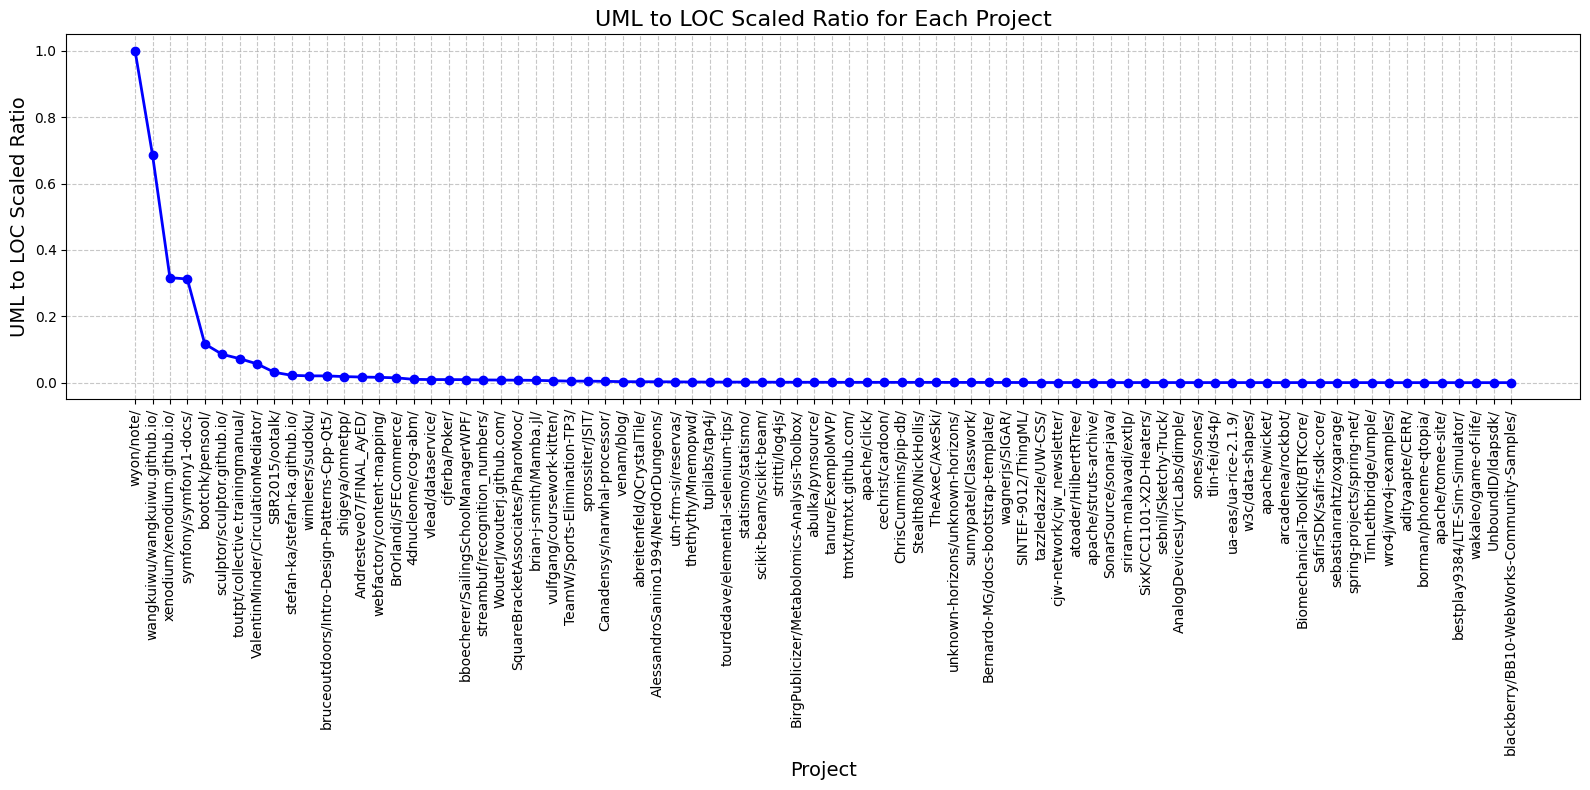

In [16]:
import matplotlib.pyplot as plt

# Plot the UML_LOC_ratio_scaled as a line diagram
plt.figure(figsize=(16, 8))
plt.plot(sampled_class_diagrams_df['Project'], sampled_class_diagrams_df['UML_LOC_ratio_scaled'], marker='o', linestyle='-', color='b', markersize=6, linewidth=2)

# Add labels and title
plt.xlabel('Project', fontsize=14)
plt.ylabel('UML to LOC Scaled Ratio', fontsize=14)
plt.title('UML to LOC Scaled Ratio for Each Project', fontsize=16)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

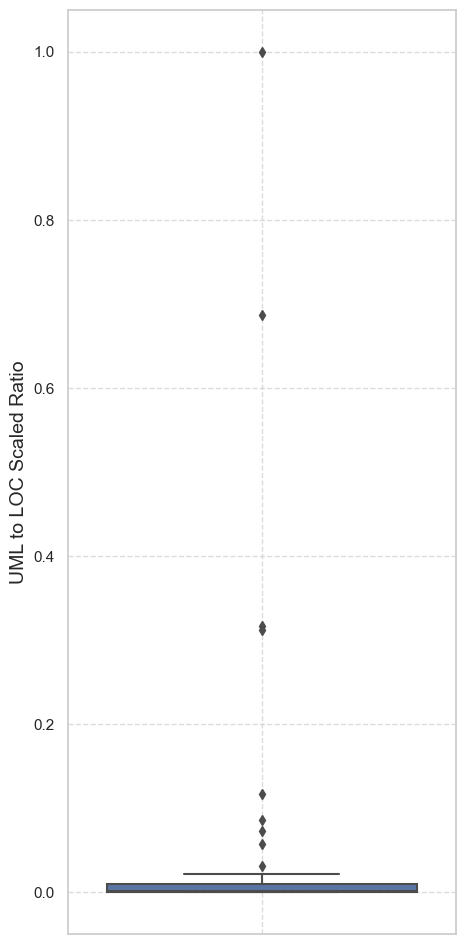

In [5]:
import seaborn as sns

# Set the style
sns.set(style="whitegrid")

# Create the box plot with a different color palette
plt.figure(figsize=(5, 12))
boxplot = sns.boxplot(data=sampled_class_diagrams_df, y='UML_LOC_ratio_scaled')

# Add labels and title
plt.ylabel('UML to LOC Scaled Ratio', fontsize=14)

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.7)

# Label the anomalies with project names
for i, point in sampled_class_diagrams_df.iterrows():
    if point['UML_LOC_ratio_scaled'] > boxplot.get_ylim()[1] or point['UML_LOC_ratio_scaled'] < boxplot.get_ylim()[0]:
        plt.text(0, point['UML_LOC_ratio_scaled'], point['Project'], horizontalalignment='left', size='medium', color='black', weight='semibold')

# Show the plot
plt.show()

### Outliers (Stars)

In [14]:
sampled_class_diagrams_df = pd.read_csv("class_diagrams_df.csv")

# sort desc
sampled_class_diagrams_df = sampled_class_diagrams_df.sort_values(by='Stargazers', ascending=False).reset_index(drop=True)
out_sampled_cd_df_stars = sampled_class_diagrams_df[:9]
out_sampled_cd_df_stars.to_csv("out_sampled_cd_df_stars.csv")
out_sampled_cd_df_stars

,Project,Last_Activity,Contributors,Stargazers,Lines_of_Code,UML_LOC_ratio_scaled,Class_Diagram_Files,No_of_Class_Diagrams,Archived_Commit_SHA,Archived_Class_Diagram_Files,No_of_Archived_Class_Diagrams
0,wakaleo/game-of-life/,2024-11-12 11:04:29+00:00,6,2037,43114062,6.630000e-06,['gameoflife-web/tools/jmeter/docs/images/scre...,1,ce7a8345329907ef9596bb7b51887602277763c6,['gameoflife-web/tools/jmeter/docs/images/scre...,1
1,unknown-horizons/unknown-horizons/,2024-11-12 20:23:59+00:00,30,1426,3032021,7.058900e-04,"['development/road-directions.png', 'developme...",4,840bd1a6a2795a96435181b1954c8820f8e9590b,['development/uml/components_design.png'],1
2,SonarSource/sonar-java/,2024-11-14 16:49:45+00:00,30,1133,18215625,3.199260e-04,['its/plugin/projects/struts-1.3.9-lite/taglib...,11,10302ab01003933abf482ca9b77c9a9cecbdbb60,['its/plugin/projects/struts-1.3.9-lite/taglib...,2
3,spring-projects/spring-net/,2024-11-06 04:08:08+00:00,30,851,14838981,1.031940e-04,['doc/reference/src/images/Migration_App_UML_D...,3,8aeb95320a96bb2759a5d756632f23ebb775abc8,['doc/reference/src/images/Migration_App_UML_D...,2
4,apache/wicket/,2024-11-10 21:10:53+00:00,30,739,14241323,1.456560e-04,['wicket-user-guide/src/main/asciidoc/img/uml-...,4,4c0c2d5d5b40bacfb4e9f169015b92953a8e3ef3,['wicket-user-guide/src/docs/img/mywebapp-clas...,4
5,stritti/log4js/,2024-10-25 17:21:56+00:00,8,449,420200,1.278094e-03,['log4js-site/xdocs/resources/images/Log4JS-UM...,1,7e876c43d7a077f6bbb341ed4f6a8af76584e415,['log4js-site/xdocs/resources/images/Log4JS-UM...,1
6,UnboundID/ldapsdk/,2024-11-13 22:03:09+00:00,1,338,88974637,1.820000e-07,['ext/ant/manual/Tasks/image-classdiagram.gif'],1,b8fb23d5d9e4bff81ccad16b66783c032cdbda06,['ext/ant/manual/Tasks/image-classdiagram.gif'],1
7,abulka/pynsource/,2024-11-09 15:06:43+00:00,4,287,7428438,1.083567e-03,"['src/dialogs/help-images/help-ascii.jpg', 'sr...",15,b1b6d8cdc19d3a59c194caebce3e80e838468780,"['Admin/doco-uml/OGL-like UML.png', 'Research/...",8
8,tourdedave/elemental-selenium-tips/,2024-05-18 08:18:30+00:00,8,285,332847,1.615064e-03,['vendor/apache-jmeter-2.11/docs/images/screen...,1,fc020aef9ae2937bc946cb008dfc19dc3c8e3ab8,['vendor/apache-jmeter-2.11/docs/images/screen...,1


In [9]:
sampled_class_diagrams_df['No_of_Class_Diagrams'].sum()

735

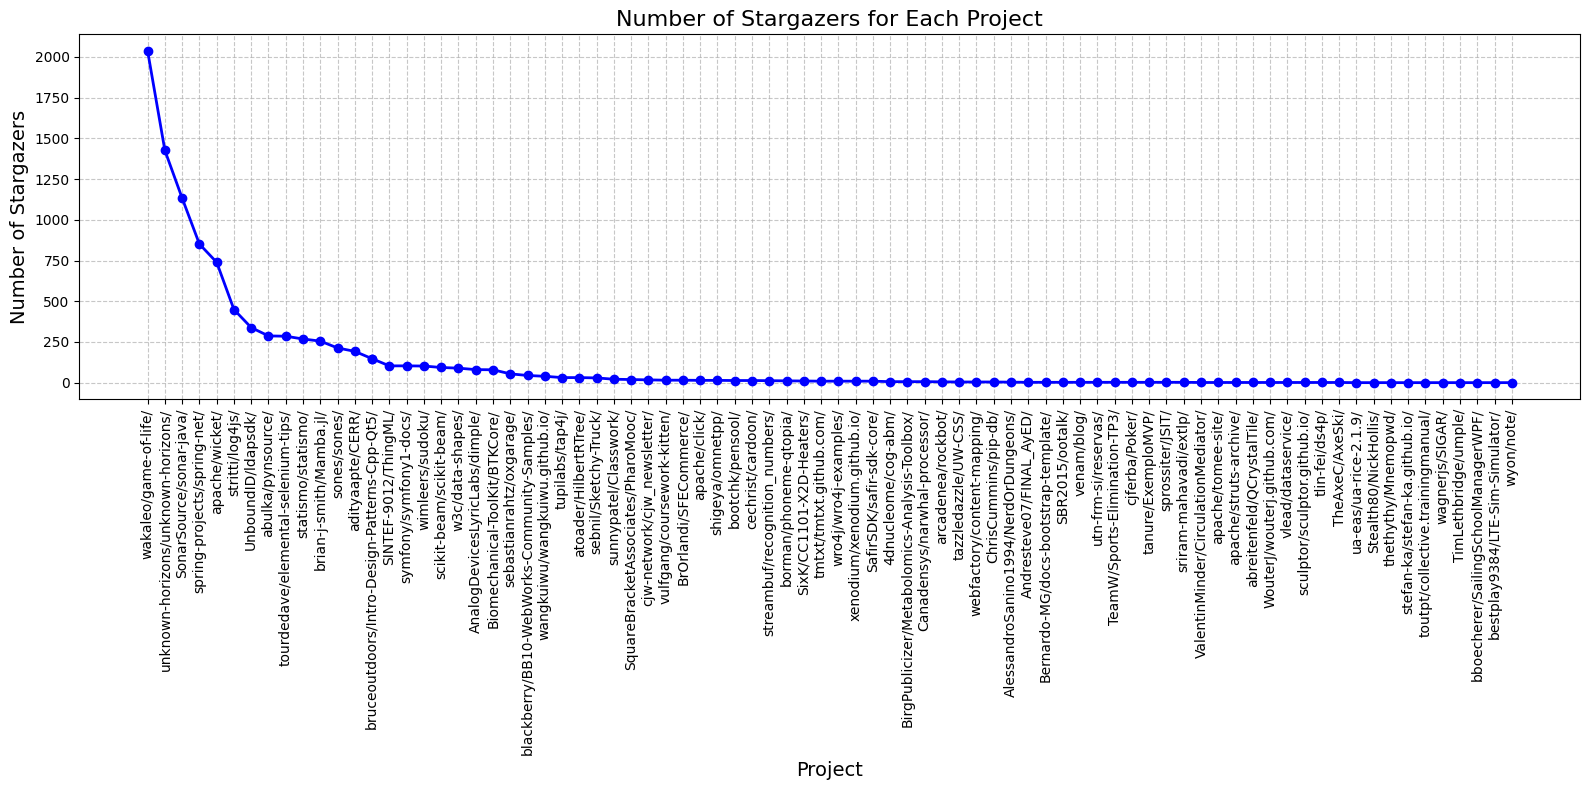

In [10]:
import matplotlib.pyplot as plt

# Plot the number of stargazers as a line diagram
plt.figure(figsize=(16, 8))
plt.plot(sampled_class_diagrams_df['Project'], sampled_class_diagrams_df['Stargazers'], marker='o', linestyle='-', color='b', markersize=6, linewidth=2)

# Add labels and title
plt.xlabel('Project', fontsize=14)
plt.ylabel('Number of Stargazers', fontsize=14)
plt.title('Number of Stargazers for Each Project', fontsize=16)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

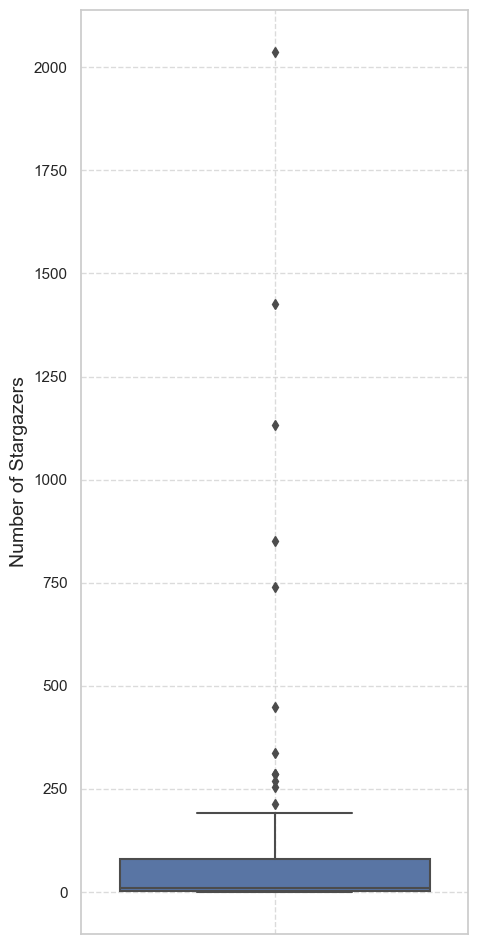

In [11]:
import seaborn as sns

# Set the style
sns.set(style="whitegrid")

# Create the box plot with a different color palette
plt.figure(figsize=(5, 12))
boxplot = sns.boxplot(data=sampled_class_diagrams_df, y='Stargazers')

# Add labels and title
plt.ylabel('Number of Stargazers', fontsize=14)

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.7)

# Label the anomalies with project names
for i, point in sampled_class_diagrams_df.iterrows():
    if point['Stargazers'] > boxplot.get_ylim()[1] or point['Stargazers'] < boxplot.get_ylim()[0]:
        plt.text(0, point['Stargazers'], point['Project'], horizontalalignment='left', size='medium', color='black', weight='semibold')

# Show the plot
plt.show()

### Outliers

In [ ]:
out_sampled_cd_df_umlloc = sampled_class_diagrams_df[:9]
out_sampled_cd_df_umlloc

,Project,Last_Activity,Contributors,Stargazers,Lines_of_Code,UML_LOC_ratio_scaled,Class_Diagram_Files,No_of_Class_Diagrams,Archived_Commit_SHA,Archived_Class_Diagram_Files,No_of_Archived_Class_Diagrams
0,wyon/note/,2024-08-23 06:52:12+00:00,1,0,11330,1.000000,"['design_patterns/img/patterns_bridge.png', 'd...",21,0b14ba465611c32cbd13502991634d5236d47889,"['design_patterns/img/uml_aggregation.gif', 'd...",7
1,wangkuiwu/wangkuiwu.github.io/,2024-07-06 09:02:06+00:00,3,39,34570,0.686693,"['media/pic/design_patterns/pattern17_01.jpg',...",44,b9a5d1f7f2d70b0be69cd47c90c0db32d0283a0e,"['media/pic/uml/uml03-04.jpg', 'media/pic/uml/...",2
2,xenodium/xenodium.github.io/,2024-11-13 13:22:10+00:00,3,9,1705,0.316432,['images/plantuml-example/plantuml-singer.png'],1,1c76be754b1054b93dbe35f3f0c825d257438315,['images/plantuml-example/plantuml-singer.png'],1
3,symfony/symfony1-docs/,2024-11-03 23:17:58+00:00,30,103,5181,0.312401,"['gentle-introduction/en/images/F1401.png', 'g...",3,d26edd9aa93dcf63d29e447abdbdda4138aaad0c,['jobeet/images/03/diagram.png'],1
4,bootchk/pensool/,2024-08-27 18:42:08+00:00,1,13,268079,0.116723,['doc/html/uml_class_diagram_for_source_g_19.g...,58,3dcc7cea3eb37a70b2baa0dc8817a29a15bbfed4,['doc/html/uml_class_diagram_for_pensool_.gif'...,56
5,sculptor/sculptor.github.io/,2024-09-18 06:28:58+00:00,30,1,37929,0.085342,['images/documentation/event-driven-tutorial/u...,6,632071a44bc6f2c39046cbaaa8c04c0709617cc2,['images/2010-03-20-improved-graphviz-visualiz...,5
6,toutpt/collective.trainingmanual/,2024-03-29 16:08:48+00:00,4,0,52203,0.072340,['developpeur/source/uml/uml_repr_diagramme_ob...,7,05c79bb105f04769f3f37a60bdded60fe5f492b3,['developpeur/source/archgenxml/argouml_ajout_...,10
7,ValentinMinder/CirculationMediator/,2024-05-02 14:47:54+00:00,3,1,47692,0.056558,['TheoreticalMediator/presentation/graphics/UM...,5,4c9c204e964a255319fe9750b3325a484441e8d6,['TheoreticalMediator/presentation/graphics/UM...,5
8,SBR2015/ootalk/,2024-01-02 20:48:05+00:00,9,2,52134,0.031041,"['misc/UML/final/class.png', 'misc/UML/now_cla...",3,1defea6bb3f2c89792f9bd61308633842d1505ca,['misc/UML/teacher/UML.png'],1


In [ ]:
out_sampled_cd_df_umlloc.to_csv("out_sampled_cd_df_umlloc.csv", index=False)

In [12]:
out_sampled_cd_df = sampled_class_diagrams_df[:11]
out_sampled_cd_df

,Project,Last_Activity,Contributors,Stargazers,Lines_of_Code,UML_LOC_ratio_scaled,Class_Diagram_Files,No_of_Class_Diagrams,Archived_Commit_SHA,Archived_Class_Diagram_Files,No_of_Archived_Class_Diagrams
0,wakaleo/game-of-life/,2024-11-12 11:04:29+00:00,6,2037,43114062,6.630000e-06,['gameoflife-web/tools/jmeter/docs/images/scre...,1,ce7a8345329907ef9596bb7b51887602277763c6,['gameoflife-web/tools/jmeter/docs/images/scre...,1
1,unknown-horizons/unknown-horizons/,2024-11-12 20:23:59+00:00,30,1426,3032021,7.058900e-04,"['development/road-directions.png', 'developme...",4,840bd1a6a2795a96435181b1954c8820f8e9590b,['development/uml/components_design.png'],1
2,SonarSource/sonar-java/,2024-11-14 16:49:45+00:00,30,1133,18215625,3.199260e-04,['its/plugin/projects/struts-1.3.9-lite/taglib...,11,10302ab01003933abf482ca9b77c9a9cecbdbb60,['its/plugin/projects/struts-1.3.9-lite/taglib...,2
3,spring-projects/spring-net/,2024-11-06 04:08:08+00:00,30,851,14838981,1.031940e-04,['doc/reference/src/images/Migration_App_UML_D...,3,8aeb95320a96bb2759a5d756632f23ebb775abc8,['doc/reference/src/images/Migration_App_UML_D...,2
4,apache/wicket/,2024-11-10 21:10:53+00:00,30,739,14241323,1.456560e-04,['wicket-user-guide/src/main/asciidoc/img/uml-...,4,4c0c2d5d5b40bacfb4e9f169015b92953a8e3ef3,['wicket-user-guide/src/docs/img/mywebapp-clas...,4
5,stritti/log4js/,2024-10-25 17:21:56+00:00,8,449,420200,1.278094e-03,['log4js-site/xdocs/resources/images/Log4JS-UM...,1,7e876c43d7a077f6bbb341ed4f6a8af76584e415,['log4js-site/xdocs/resources/images/Log4JS-UM...,1
6,UnboundID/ldapsdk/,2024-11-13 22:03:09+00:00,1,338,88974637,1.820000e-07,['ext/ant/manual/Tasks/image-classdiagram.gif'],1,b8fb23d5d9e4bff81ccad16b66783c032cdbda06,['ext/ant/manual/Tasks/image-classdiagram.gif'],1
7,abulka/pynsource/,2024-11-09 15:06:43+00:00,4,287,7428438,1.083567e-03,"['src/dialogs/help-images/help-ascii.jpg', 'sr...",15,b1b6d8cdc19d3a59c194caebce3e80e838468780,"['Admin/doco-uml/OGL-like UML.png', 'Research/...",8
8,tourdedave/elemental-selenium-tips/,2024-05-18 08:18:30+00:00,8,285,332847,1.615064e-03,['vendor/apache-jmeter-2.11/docs/images/screen...,1,fc020aef9ae2937bc946cb008dfc19dc3c8e3ab8,['vendor/apache-jmeter-2.11/docs/images/screen...,1
9,statismo/statismo/,2024-11-02 12:32:09+00:00,12,268,1050303,1.535179e-03,"['doc/IJ/pictures/class_diagram.png', 'doc/IJ/...",3,7ffc10d66e9d8586532b41c34e307da13c21e014,"['doc/IJ/pictures/class_diagram.png', 'doc/IJ/...",3


In [13]:
out_sampled_cd_df.to_csv("out_sampled_cd_df_stars.csv", index=False)